## Dataset Insights

In [5]:
import json
import math
import os
import sqlite3
import sys
import types

from functools import partial

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from osgeo import gdal

# Allow import from src dir
sys.path.append("../..")

from src.utils.db import dict_factory, get_dataset_labels


# Instantiate DB conn
metadata_path = "../metadata.sqlite3"
db_path = os.path.abspath(metadata_path)
conn = sqlite3.connect(db_path)
conn.row_factory = dict_factory


##### Point Label Annotations

In [6]:
# Count point labels
dataset_id = 1
splits = ["jan-march-may-2022-point-train",
          "jan-march-may-2022-point-val",
          "jun-july-aug-2022-point-train",
          "jun-july-aug-2022-point-val",
          "apr-2022-point-train",
          "apr-2022-point-val",
          "nov-2021-point-train", 
          "nov-2021-point-val",  
          "jun-2020-point-train",
          "jun-2020-point-val"]
labels_by_split = {split: get_dataset_labels(conn, dataset_id, splits=[split]) for split in splits}
all_labels = []
for split, labels in labels_by_split.items():
    all_labels.extend(labels)
print(f"{len(all_labels)} total point labels.")


61655 total point labels.


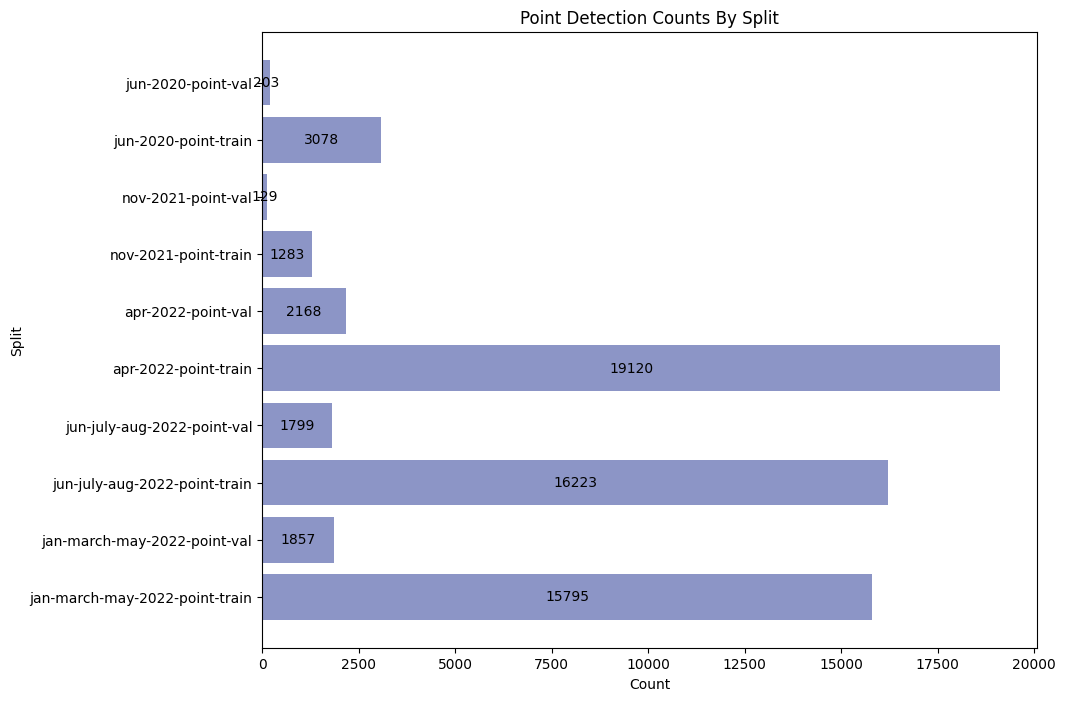

In [7]:
# Hist of point detections by split
data = []
columns = []
for split, labels in labels_by_split.items():
    data.append(len(labels))
    columns.append(split)
X = np.arange(len(data))

# Get some pastel shades for the colors
color = plt.cm.BuPu(.5)

index = np.arange(len(data))
bar_width = .8

fig, ax = plt.subplots(figsize=(10, 8))
bar = ax.barh(columns, data, bar_width, color=color)
ax.bar_label(bar, label_type="center")
plt.ylabel("Split")
plt.xlabel("Count")
plt.yticks(X)
plt.title('Point Detection Counts By Split')

plt.show()


In [8]:
# Utilities for extracting lat/lon from labels
WEB_MERCATOR_M = 2 * math.pi * 6378137


def pixel_to_crs(point, zoom=13, tile_size=512):
    """Get absolute Web Mercator coordinates given pixel coordinates on a specified Web-Mercator tiling."""
    x, y = point[0], point[1]

    # Number of web-mercator meter units covered by a single
    # pixel in a tiling with (tile_size x tile_size) pixels and zoom.
    tile_pixel_size = WEB_MERCATOR_M / (tile_size * (2**zoom))

    x *= tile_pixel_size
    y *= tile_pixel_size
    x = x - (WEB_MERCATOR_M / 2)
    y = WEB_MERCATOR_M - (y + (WEB_MERCATOR_M / 2))

    return (x, y)

def crs_to_pixel(point, zoom=13, tile_size=512):
    """Get pixel coordinates on a specified Web-Mercator tiling given absolute Web Mercator coordinates."""
    x, y = point[0], point[1]
    
    # Translate coordinates to pos. quadrant
    x = x + (WEB_MERCATOR_M / 2)
    y = y + (WEB_MERCATOR_M / 2)
    
    # Reverse y coordinate
    y = WEB_MERCATOR_M - y
    
    num_tiles = 2**zoom
    num_pixels = num_tiles*tile_size
    
    x_crs_ratio = x / WEB_MERCATOR_M
    y_crs_ratio = y / WEB_MERCATOR_M
    
    x_pixel = x_crs_ratio*num_pixels
    y_pixel = y_crs_ratio*num_pixels
    
    return (x_pixel, y_pixel)


def get_lat_lon(col, row, transformer, zoom=13, tile_size=512):
    """"Get latitude and longitude for points specified in pixel coordinates on a specified Web-Mercator tiling."""
    col, row = pixel_to_crs((col, row), zoom, tile_size)
    success, point = transformer.TransformPoint(0, float(col), float(row), 0)
    lon, lat, _ = point
    return lat, lon


get_lat_lon = partial(get_lat_lon, transformer=gdal.Transformer(None, None, ['SRC_SRS=epsg:3857', 'DST_SRS=WGS84']))


def construct_lat_lon_df(labels, save_path=None):
    """Construct a dataframe of latitudes and longitudes for given point labels."""
    lats = []
    lons = []
    for label in labels:
        col, row = label["column"], label["row"]
        lat, lon = get_lat_lon(col, row)
        lats.append(lat)
        lons.append(lon)

    d = {'Latitude': lats, 'Longitude': lons}
    df = pd.DataFrame(data=d)
    if save_path:
        df.to_csv(save_path, index=False)
    return df


In [5]:
# Record lat/long for point labels in each split (TODO: plot loc distributions here)
for split, labels in labels_by_split.items():
    split_df = construct_lat_lon_df(labels, save_path=f"{split}_coords.csv")
full_df = construct_lat_lon_df(all_labels, save_path=f"full_coords.csv")


##### Attribute Annotations

In [6]:
# Get attribute labels
splits = ["jan-march-may-2022-attrs-train", "jun-july-aug-2022-attrs-train", "apr-2022-attrs-train",
          "jan-march-may-2022-attrs-val", "jun-july-aug-2022-attrs-val", "apr-2022-attrs-val"]
dataset_id = 2
attr_labels_by_split = {split: get_dataset_labels(conn, dataset_id, splits=[split]) for split in splits}
all_attr_labels = []
for split, labels in attr_labels_by_split.items():
    all_attr_labels.extend(labels)


def get_attribute_dists(labels):
    """Extract individual attribute labels from attribute label dict."""
    lengths = []
    widths = []
    headings = []
    ship_types = []
    speeds = []
    prop_dicts = [json.loads(label["properties"]) for label in labels]
    lengths.extend([prop_dict["Length"] for prop_dict in prop_dicts])
    widths.extend([prop_dict["Width"] for prop_dict in prop_dicts])
    headings.extend([prop_dict["Heading"] for prop_dict in prop_dicts])
    ship_types.extend([prop_dict["ShipAndCargoType"] for prop_dict in prop_dicts])
    speeds.extend([prop_dict["Speed"] for prop_dict in prop_dicts])
    return lengths, widths, headings, ship_types, speeds


In [7]:
def get_fishing_ratio(ship_types):
    """"Get ratio of labels reported with fishing vessel type"""

    # Ship Counts by Type
    ship_types, ship_counts = np.unique(ship_types, return_counts=True)
    count_sort_idx = np.argsort(-ship_counts)
    ship_types, ship_counts = ship_types[count_sort_idx], ship_counts[count_sort_idx]

    # Fishing Count
    fishing_index_locs = np.where(ship_types == 30)[0]
    if len(fishing_index_locs) > 0:
        fishing_index = np.where(ship_types == 30)[0][0]
        fishing_ships = ship_counts[fishing_index]
    else:
        fishing_ships = 0
    total_ships = ship_counts.sum()
    pos_weight = total_ships / fishing_ships
    print(f"\tAnnotations of fishing vessels: {fishing_ships}/{total_ships} = {round(fishing_ships/total_ships, 2)}%")
    return ship_types, ship_counts, fishing_index


# Get fishing counts per split
for split, attr_labels in attr_labels_by_split.items():
    lengths, widths, headings, ship_types, speeds = get_attribute_dists(attr_labels)
    print(f"Split: {split}")
    _, _, _ = get_fishing_ratio(ship_types)

# Get all attributes for total dataset
lengths, widths, headings, ship_types, speeds = get_attribute_dists(all_attr_labels)
print(f"Total Dataset:")
ship_types, ship_counts, fishing_index = get_fishing_ratio(ship_types)


Split: jan-march-may-2022-attrs-train
	Annotations of fishing vessels: 87/5553 = 0.02%
Split: jun-july-aug-2022-attrs-train
	Annotations of fishing vessels: 199/5332 = 0.04%
Split: apr-2022-attrs-train
	Annotations of fishing vessels: 201/4939 = 0.04%
Split: jan-march-may-2022-attrs-val
	Annotations of fishing vessels: 10/617 = 0.02%
Split: jun-july-aug-2022-attrs-val
	Annotations of fishing vessels: 22/592 = 0.04%
Split: apr-2022-attrs-val
	Annotations of fishing vessels: 22/549 = 0.04%
Total Dataset:
	Annotations of fishing vessels: 541/17582 = 0.03%


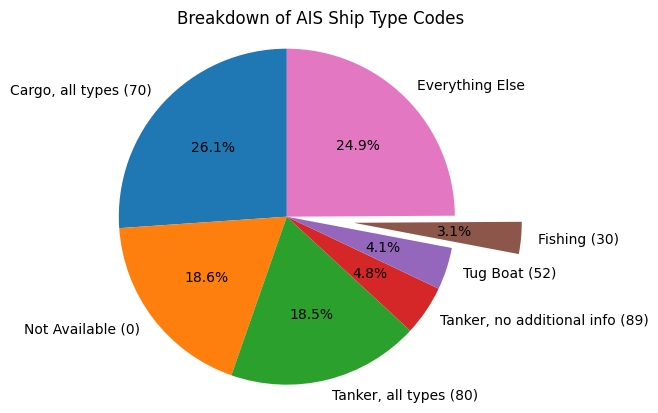

In [8]:
# Plot Distribution of Ship Types
code_to_type = {0: "Not Available", 70: "Cargo, all types", 80: "Tanker, all types", 89: "Tanker, no additional info",
                52: "Tug Boat", 30: "Fishing", 90: "Other Type, all ships of this type",
                79: "Cargo, no additional info", 37: "Pleasure Craft", 71: "Cargo, hazardous category A"}

num_types = 5
labels = list(ship_types[:num_types])
sizes = list(ship_counts[:num_types])
if fishing_index >= num_types:
    labels.append(ship_types[fishing_index])
    sizes.append(ship_counts[fishing_index])
labels = [f"{code_to_type[label]} " + f"({label})" for label in labels]
labels.append("Everything Else")
sizes.append(ship_counts.sum() - sum(sizes))
explode = len(sizes) * [0]
explode[len(sizes) - 2] = .4

fig1, ax1 = plt.subplots()
ax1.pie(sizes,
        explode=explode,
        labels=labels,
        autopct='%1.1f%%',
        shadow=False, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Breakdown of AIS Ship Type Codes')
plt.show()


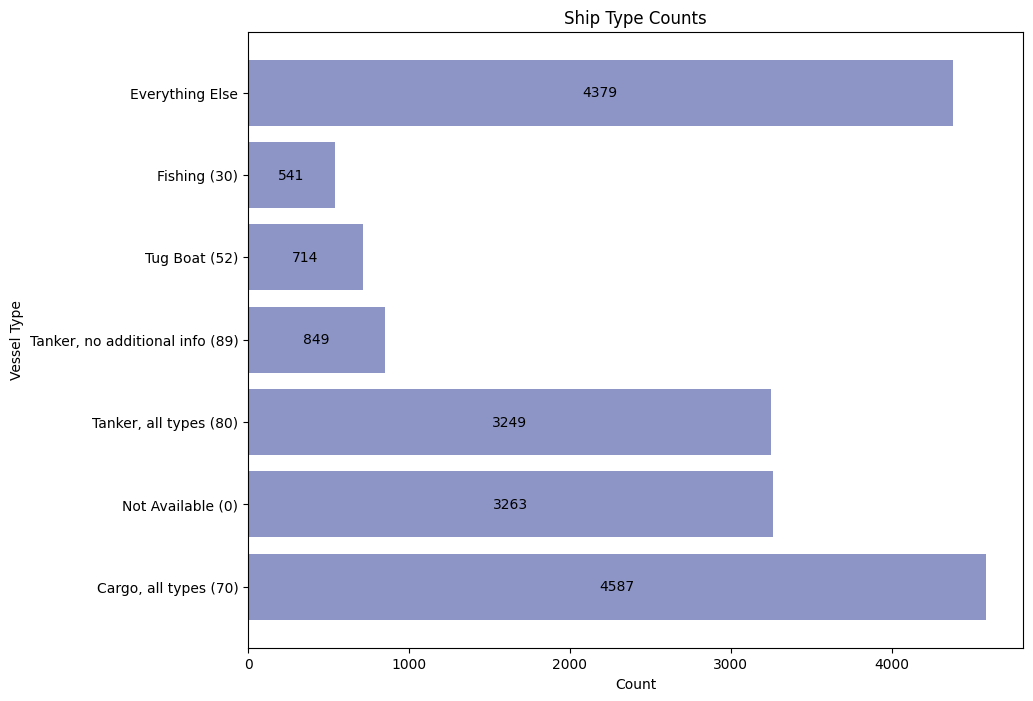

In [9]:
# Same data as bar plot

X = np.arange(len(sizes))

# Get some pastel shades for the colors
color = plt.cm.BuPu(.5)

index = np.arange(len(sizes))
bar_width = .8

fig, ax = plt.subplots(figsize=(10, 8))
bar = ax.barh(labels, sizes, bar_width, color=color)
ax.bar_label(bar, label_type="center")
plt.ylabel("Vessel Type")
plt.xlabel("Count")
plt.yticks(X)
plt.title('Ship Type Counts')

plt.show()


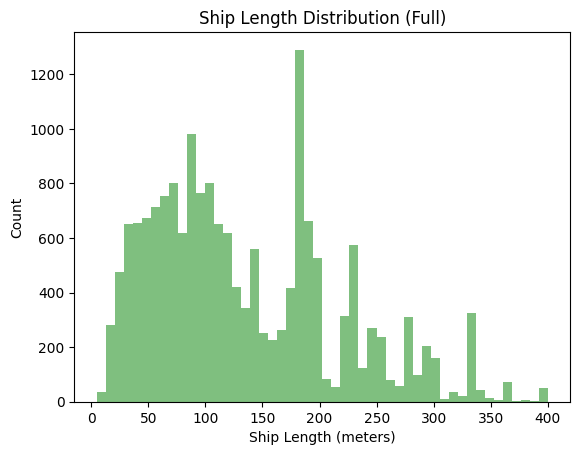

In [10]:
# Length histogram

n, bins, patches = plt.hist(lengths, 50, density=False, facecolor='g', alpha=0.5)


plt.xlabel('Ship Length (meters)')
plt.ylabel('Count')
plt.title('Ship Length Distribution (Full)')
plt.grid(False)
plt.show()


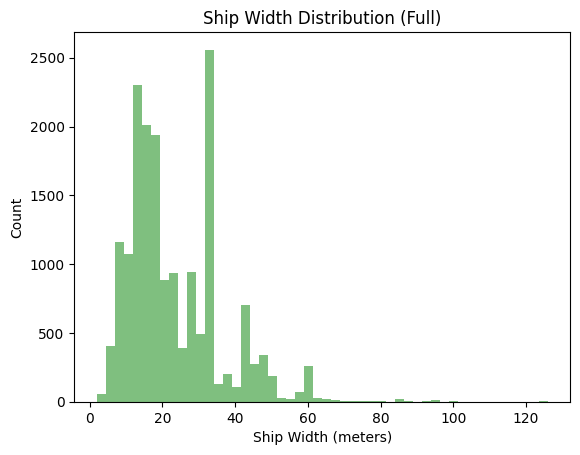

In [11]:
# Width histogram

n, bins, patches = plt.hist(widths, 50, density=False, facecolor='g', alpha=0.5)


plt.xlabel('Ship Width (meters)')
plt.ylabel('Count')
plt.title('Ship Width Distribution (Full)')
plt.grid(False)
plt.show()


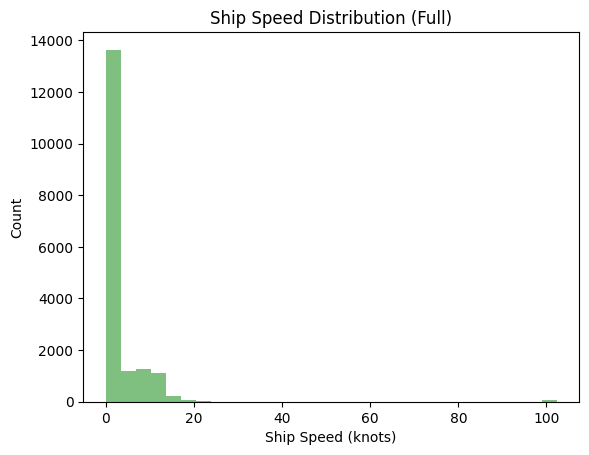

In [12]:
# Speed histogram

n, bins, patches = plt.hist(speeds, 30, density=False, facecolor='g', alpha=0.5)


plt.xlabel('Ship Speed (knots)')
plt.ylabel('Count')
plt.title('Ship Speed Distribution (Full)')
plt.grid(False)
plt.show()


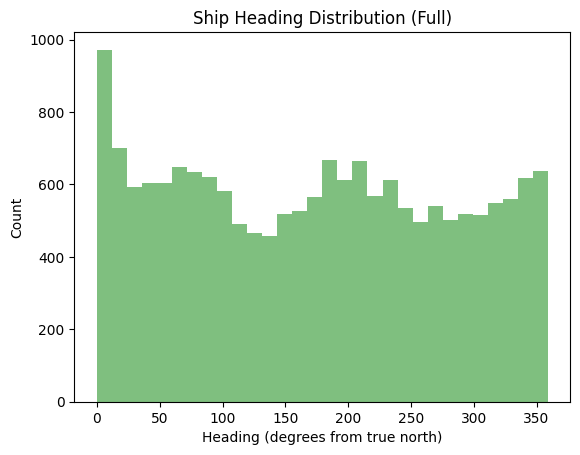

In [13]:
# Heading histogram

n, bins, patches = plt.hist(headings, 30, density=False, facecolor='g', alpha=0.5)


plt.xlabel('Heading (degrees from true north)')
plt.ylabel('Count')
plt.title('Ship Heading Distribution (Full)')
plt.grid(False)
plt.show()
